In [1]:
# Fist install the library

#%pip install aepy

In [2]:
import os
import sys

notebook_dir = os.path.abspath('')
sys.path.append(os.path.join(notebook_dir, '..'))
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np

from sklearn.metrics import accuracy_score
from keras import utils

from rapidae.data.datasets import load_MNIST
from rapidae.data.utils import evaluate, display_diff, add_noise
from rapidae.models.vq_vae.vq_vae_model import VQ_VAE
from rapidae.models.base.default_architectures import Encoder_Conv_VQ_MNIST, Decoder_Conv_VQ_MNIST
from rapidae.pipelines.training import TrainingPipeline

2023-12-23 14:50:51.985958: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-23 14:50:51.985986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-23 14:50:51.986735: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-23 14:50:51.991817: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-23 14:50:52.554897: W tensorflow/compiler/tf2

In [3]:
# Load MNIST dataset
x_train, y_train, x_test, y_test = load_MNIST(persistant=True)

# Obtaint number of clasess
n_classes = len(set(y_train))

# Convert labels to categorical
y_train = utils.to_categorical(y_train, n_classes)
y_test = utils.to_categorical(y_test, n_classes)

2023-12-23 14:50:53 [INFO]: train-images-idx3-ubyte.gz already exists.
2023-12-23 14:50:53 [INFO]: train-labels-idx1-ubyte.gz already exists.
2023-12-23 14:50:53 [INFO]: t10k-images-idx3-ubyte.gz already exists.
2023-12-23 14:50:53 [INFO]: t10k-labels-idx1-ubyte.gz already exists.


In [4]:
train_data = dict(data=x_train.astype(float), labels=x_train)
test_data = dict(data=x_test.astype(float), labels=y_test)

In [5]:
# Model creation
model = VQ_VAE(input_dim=(x_train.shape[1], x_train.shape[2]), 
            latent_dim=2, encoder=Encoder_Conv_VQ_MNIST, decoder=Decoder_Conv_VQ_MNIST, layers_conf=[32, 64])

#model.jit_compile = False

2023-12-23 14:50:53.682013: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-12-23 14:50:53.682037: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: DebianLPC
2023-12-23 14:50:53.682041: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: DebianLPC
2023-12-23 14:50:53.682120: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 545.23.8
2023-12-23 14:50:53.682132: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 545.23.8
2023-12-23 14:50:53.682135: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 545.23.8


In [6]:
pipe = TrainingPipeline(name='training_pipeline',
                        model=model, num_epochs=2)

trained_model = pipe(x=x_train.astype(float), y=y_train)

2023-12-23 14:50:53 [INFO]: +++ training_pipeline +++
2023-12-23 14:50:53 [INFO]: Creating folder in ../output_dir/training_pipeline_2023-12-23_14-50-53


Epoch 1/2


/home/lucaspc/venvs/keras_core/lib/python3.11/site-packages/keras/src/layers/layer.py:358: UserWarning: `build()` was called on layer 'encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Epoch 1: loss improved from inf to 1547.41577, saving model to ../output_dir/training_pipeline_2023-12-23_14-50-53/model.weights.h5
469/469 - 36s - 77ms/step - loss: 1547.4158 - reconstruction_loss: 1041.2850 - vq_loss: 506.1303
Epoch 2/2

Epoch 2: loss improved from 1547.41577 to 582.90894, saving model to ../output_dir/training_pipeline_2023-12-23_14-50-53/model.weights.h5
469/469 - 35s - 75ms/step - loss: 582.9089 - reconstruction_loss: 420.4088 - vq_loss: 162.5004


In [7]:
import matplotlib.pyplot as plt

def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()

(9, 28, 28, 1)
(10000, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
(9, 28, 28, 1)
(9, 28, 28, 1)


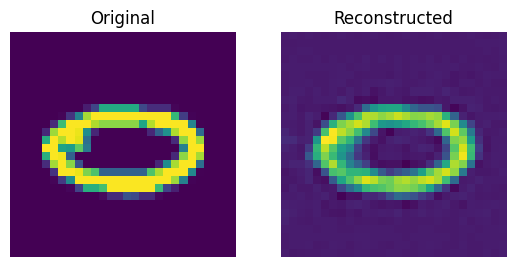

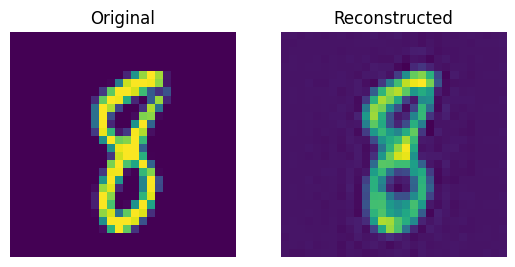

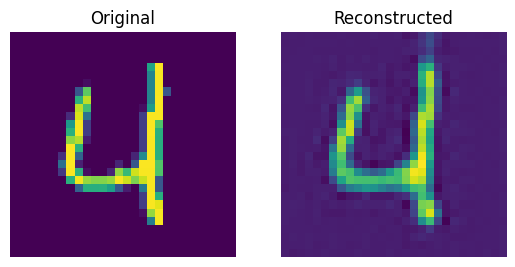

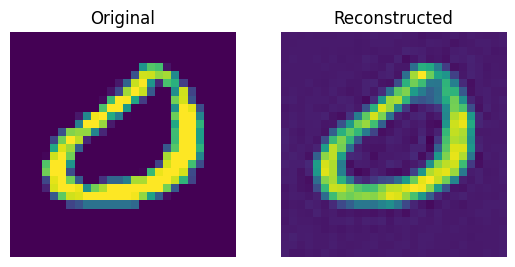

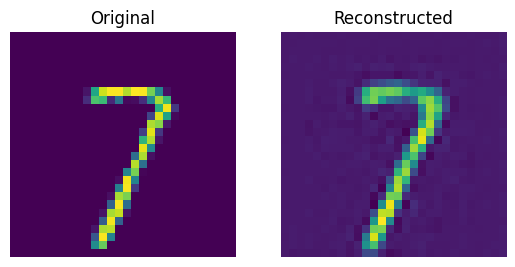

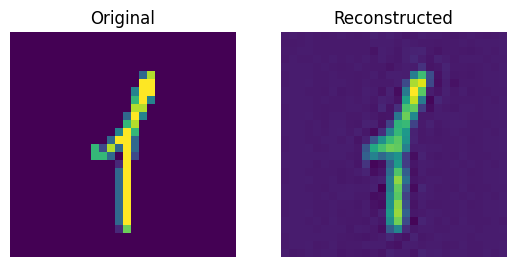

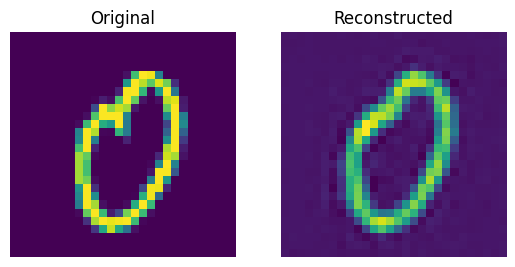

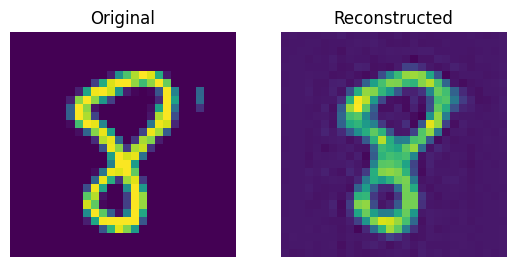

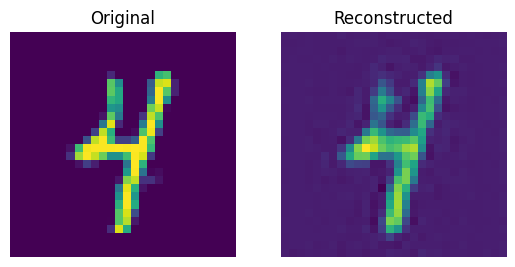

In [8]:
idx = np.random.choice(len(x_test), 9)

test_images = x_test[idx]
test_labels = y_test[idx]

print(test_images.shape)
print(x_test.shape)

#test_data = dict(data=test_images.astype(float), labels=test_labels)

reconstructions_test = trained_model.predict(test_images.astype(float))

#print(reconstructions_test['recon'])
print(test_images.shape)
print(reconstructions_test['recon'].shape)

for test_image, reconstructed_image in zip(test_images, reconstructions_test['recon']):
    show_subplot(test_image, reconstructed_image)